## Import Libraries

In [139]:
### framework files
import import_files as MrtRecommendationDependencies
from ridership_transformer import RidershipTransformer

### standard libs
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### stat libs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose


## Process Dataset

### Load Dataset

In [7]:
df = pd.read_csv(MrtRecommendationDependencies.get_dataset_path("cubao.csv"), parse_dates=['date'])

In [111]:
df.head(40)

,date,time,entry,exit
0,2019-01-01,04:00 - 04:59,0,0
1,2019-01-01,05:00 - 05:59,0,0
2,2019-01-01,06:00 - 06:59,239,22
3,2019-01-01,07:00 - 07:59,413,525
4,2019-01-01,08:00 - 08:59,454,627
5,2019-01-01,09:00 - 09:59,640,595
6,2019-01-01,10:00 - 10:59,866,842
7,2019-01-01,11:00 - 11:59,1176,892
8,2019-01-01,12:00 - 12:59,1251,1174
9,2019-01-01,13:00 - 13:59,1273,1206


### Transform Dataset

In [24]:
transformed_df = RidershipTransformer(df).transform()
transformed_df.head()

,datetime,entry,exit
0,2019-01-01 04:00:00,0,0
1,2019-01-01 05:00:00,0,0
2,2019-01-01 06:00:00,239,22
3,2019-01-01 07:00:00,413,525
4,2019-01-01 08:00:00,454,627


In [25]:
entry_df = transformed_df.drop('exit', axis=1)
entry_df.set_index('datetime', inplace=True)

## Visualize Data / Seasonal Decomposition

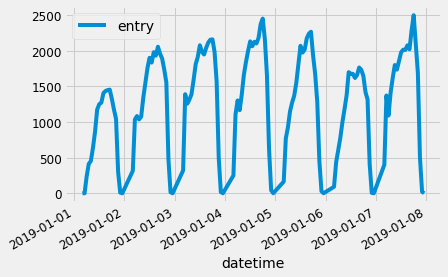

In [90]:
entry_df[0:140].plot()

### Remove 0 values

In [ ]:
two_week_copy = entry_df[0:140].copy()
two_week_copy = two_week_copy[two_week_copy.entry > 0]

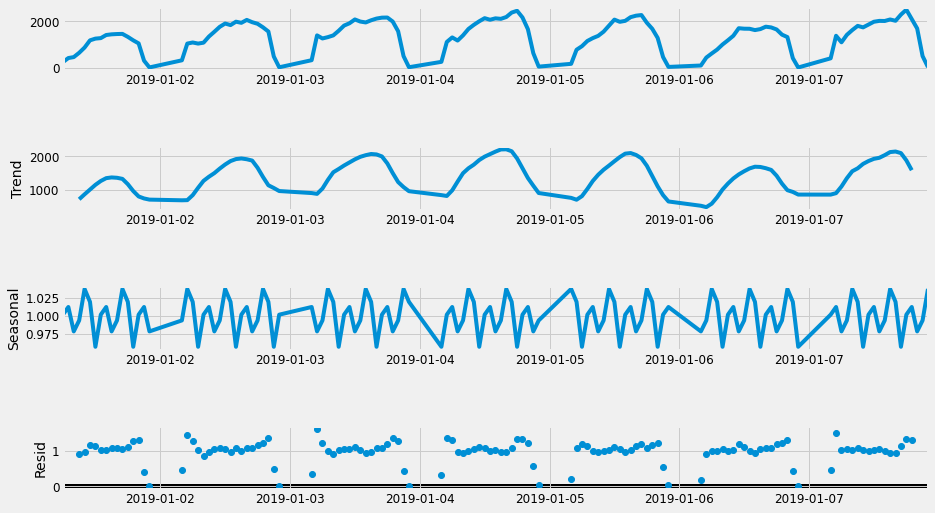

In [136]:
decomp = seasonal_decompose(two_week_copy,period=7, model="multiplicative")
fig = decomp.plot()
fig.set_size_inches(15, 8)

## Test for Stationarity 

### Augmented Dickey Fuller Test

[ADF Test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)

**Test for stationarity**: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In [148]:
def perform_adfuller(df):
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [149]:
perform_adfuller(two_week_copy)

Test Statistic                  -5.621086
p-value                          0.000001
#Lags Used                       7.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


### Kwiatkowski-Phillips-Schmidt-Shin Test

[KPSS Test](https://en.wikipedia.org/wiki/KPSS_test)

**Test for stationarity**: If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary)

In [146]:
def perform_kpss(df):
    kpsst = kpss(df)
    kpsstest = kpss(df, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)

In [147]:
perform_kpss(two_week_copy)

Test Statistic            0.195378
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
